In [1]:
import os
import yaml
import glob
import pandas as pd
import tqdm
import numpy as np

from python_scripts.simulation import step_simulation
from python_scripts.visualizer import Visualizer
from python_scripts.utilities import merge_config, save_results, load_results, single_to_batch_results
from commonroad.common.file_reader import CommonRoadFileReader

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [2]:
def plot_raw_scenario(timestep, scenario, config):
    plt.cla()
    Visualizer().plot_unsimulated(scenario, config, timestep)
    plt.axis('scaled')
    plt.xlim(0,420)
    plt.ylim(-45,-15)

def plot_result_scenario(time_step, ego_vehicle, scenarios, sensor_views):
    plt.cla()
    Visualizer().plot(scenario=scenarios[time_step],
                  sensor_view=sensor_views[time_step],
                  ego_vehicle=scenarios[time_step].obstacle_by_id(ego_vehicle.obstacle_id),
                  time_begin=time_step)
    plt.axis('scaled')
    plt.xlim(0,420)
    plt.ylim(-45,-15)

## Visualise scenario

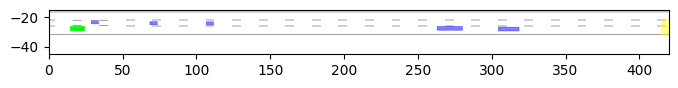

In [14]:
scenario_path = "scenarios/highd_scenarios/ZAM_HighD-10_5_T-1"

#======================================================#
with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario, _ = CommonRoadFileReader(scenario_path + ".xml").open()

fig = plt.figure(figsize=(12, 2))
anim = animation.FuncAnimation(fig, 
                               plot_raw_scenario, 
                               fargs=[scenario, config], 
                               frames=range(config["simulation_duration"]), 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())


## Run a single scenario

In [3]:
scenario_path = "scenarios/highd_scenarios/ZAM_HighD-1_1_T-1"
results_folder = "results/"


with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario1, _ = CommonRoadFileReader(scenario_path + ".xml").open()
scenario2, _ = CommonRoadFileReader(scenario_path + ".xml").open()
scenario3, _ = CommonRoadFileReader(scenario_path + ".xml").open()

config['occlusion_params']['save_shadows'] = True

config['occlusion_params']['ideal_tracking_enabled'] = False
config['occlusion_params']['velocity_tracking_enabled'] = True
tracked_results = step_simulation(scenario1, config)

config['occlusion_params']['velocity_tracking_enabled'] = False
untracked_results = step_simulation(scenario2, config)

config['occlusion_params']['ideal_tracking_enabled'] = True
config['occlusion_params']['velocity_tracking_enabled'] = True
ideal_results = step_simulation(scenario3, config)

save_path = os.path.join(results_folder, str(scenario1.scenario_id))
save_results(save_path, ideal_results, tracked_results, untracked_results, scenario1, scenario_config)

For timestep 1 min_x is 0
For timestep 2 min_x is 70.0263
For timestep 3 min_x is 70.0263
For timestep 4 min_x is 70.0263
For timestep 5 min_x is 70.0263
For timestep 6 min_x is 70.0263
For timestep 1 min_x is 0
For timestep 2 min_x is 226.549
For timestep 3 min_x is 226.549
For timestep 4 min_x is 226.549
For timestep 5 min_x is 226.549
For timestep 6 min_x is 226.549
For timestep 1 min_x is 0
For timestep 2 min_x is 89.0214
For timestep 3 min_x is 89.0214
For timestep 4 min_x is 89.0214
For timestep 5 min_x is 89.0214
For timestep 6 min_x is 89.0214
For timestep 1 min_x is 0
For timestep 2 min_x is 232.93
For timestep 3 min_x is 232.93
For timestep 4 min_x is 232.93
For timestep 5 min_x is 232.93
For timestep 6 min_x is 232.93


For timestep 1 min_x is 0
For timestep 2 min_x is 99.4279
For timestep 3 min_x is 99.4279
For timestep 4 min_x is 99.4279
For timestep 5 min_x is 99.4279
For timestep 6 min_x is 99.4279
For timestep 1 min_x is 0
For timestep 2 min_x is 239.35
For timestep 3 min_x is 239.35
For timestep 4 min_x is 239.35
For timestep 5 min_x is 239.35
For timestep 6 min_x is 239.35
For timestep 1 min_x is 0
For timestep 2 min_x is 108.012
For timestep 3 min_x is 108.012
For timestep 4 min_x is 108.012
For timestep 5 min_x is 108.012
For timestep 6 min_x is 108.012
For timestep 1 min_x is 0
For timestep 2 min_x is 245.125
For timestep 3 min_x is 245.125
For timestep 4 min_x is 245.125
For timestep 5 min_x is 245.125
For timestep 6 min_x is 245.125


For timestep 1 min_x is 0
For timestep 2 min_x is 116.505
For timestep 3 min_x is 117.525
For timestep 4 min_x is 117.525
For timestep 5 min_x is 117.525
For timestep 6 min_x is 117.525
For timestep 1 min_x is 0
For timestep 2 min_x is 249.845
For timestep 3 min_x is 249.845
For timestep 4 min_x is 249.845
For timestep 5 min_x is 249.845
For timestep 6 min_x is 249.845


For timestep 1 min_x is 0
For timestep 2 min_x is 124.977
For timestep 3 min_x is 131.205
For timestep 4 min_x is 134.933
For timestep 5 min_x is 134.933
For timestep 6 min_x is 134.933
For timestep 1 min_x is 0
For timestep 2 min_x is 254.545
For timestep 3 min_x is 254.545
For timestep 4 min_x is 254.545
For timestep 5 min_x is 254.545
For timestep 6 min_x is 254.545


For timestep 1 min_x is 0
For timestep 2 min_x is 133.59
For timestep 3 min_x is 143.24
For timestep 4 min_x is 150.39
For timestep 5 min_x is 152.54
For timestep 6 min_x is 152.54
For timestep 1 min_x is 0
For timestep 2 min_x is 259.284
For timestep 3 min_x is 259.284
For timestep 4 min_x is 259.284
For timestep 5 min_x is 259.284
For timestep 6 min_x is 259.284
For timestep 1 min_x is 0
For timestep 2 min_x is 142.052
For timestep 3 min_x is 153.896
For timestep 4 min_x is 163.241
For timestep 5 min_x is 167.585
For timestep 6 min_x is 167.585
For timestep 1 min_x is 0
For timestep 2 min_x is 263.994
For timestep 3 min_x is 263.994
For timestep 4 min_x is 263.994
For timestep 5 min_x is 263.994
For timestep 6 min_x is 263.994


For timestep 1 min_x is 0
For timestep 2 min_x is 150.582
For timestep 3 min_x is 164.114
For timestep 4 min_x is 175.146
For timestep 5 min_x is 181.178
For timestep 6 min_x is 182.209
For timestep 1 min_x is 0
For timestep 2 min_x is 268.714
For timestep 3 min_x is 268.714
For timestep 4 min_x is 268.714
For timestep 5 min_x is 268.714
For timestep 6 min_x is 268.714
For timestep 1 min_x is 0
For timestep 2 min_x is 156.806
For timestep 3 min_x is 170.371
For timestep 4 min_x is 181.435
For timestep 5 min_x is 187.499
For timestep 6 min_x is 188.564
For timestep 1 min_x is 0
For timestep 2 min_x is 273.424
For timestep 3 min_x is 273.424
For timestep 4 min_x is 273.424
For timestep 5 min_x is 273.424
For timestep 6 min_x is 273.424


For timestep 1 min_x is 0
For timestep 2 min_x is 163.032
For timestep 3 min_x is 176.623
For timestep 4 min_x is 187.713
For timestep 5 min_x is 193.803
For timestep 6 min_x is 194.894
For timestep 1 min_x is 0
For timestep 2 min_x is 278.114
For timestep 3 min_x is 278.114
For timestep 4 min_x is 278.114
For timestep 5 min_x is 278.114
For timestep 6 min_x is 278.114
For timestep 1 min_x is 0
For timestep 2 min_x is 169.249
For timestep 3 min_x is 182.864
For timestep 4 min_x is 193.979
For timestep 5 min_x is 200.094
For timestep 6 min_x is 201.208
For timestep 1 min_x is 0
For timestep 2 min_x is 282.844
For timestep 3 min_x is 282.844
For timestep 4 min_x is 282.844
For timestep 5 min_x is 282.844
For timestep 6 min_x is 282.844


For timestep 1 min_x is 0
For timestep 2 min_x is 175.467
For timestep 3 min_x is 189.093
For timestep 4 min_x is 200.219
For timestep 5 min_x is 206.344
For timestep 6 min_x is 207.47
For timestep 1 min_x is 0
For timestep 2 min_x is 287.534
For timestep 3 min_x is 287.534
For timestep 4 min_x is 287.534
For timestep 5 min_x is 287.534
For timestep 6 min_x is 287.534
For timestep 1 min_x is 0
For timestep 2 min_x is 181.675
For timestep 3 min_x is 195.189
For timestep 4 min_x is 206.204
For timestep 5 min_x is 212.219
For timestep 6 min_x is 213.234
For timestep 1 min_x is 0
For timestep 2 min_x is 292.254
For timestep 3 min_x is 292.254
For timestep 4 min_x is 292.254
For timestep 5 min_x is 292.254
For timestep 6 min_x is 292.254


For timestep 1 min_x is 0
For timestep 2 min_x is 187.852
For timestep 3 min_x is 201.153
For timestep 4 min_x is 211.953
For timestep 5 min_x is 217.754
For timestep 6 min_x is 218.554
For timestep 1 min_x is 0
For timestep 2 min_x is 296.934
For timestep 3 min_x is 296.934
For timestep 4 min_x is 296.934
For timestep 5 min_x is 296.934
For timestep 6 min_x is 296.934


For timestep 1 min_x is 0
For timestep 2 min_x is 194.042
For timestep 3 min_x is 207.078
For timestep 4 min_x is 217.614
For timestep 5 min_x is 223.149
For timestep 6 min_x is 223.685
For timestep 1 min_x is 0
For timestep 2 min_x is 301.624
For timestep 3 min_x is 301.624
For timestep 4 min_x is 301.624
For timestep 5 min_x is 301.624
For timestep 6 min_x is 301.624


For timestep 1 min_x is 0
For timestep 2 min_x is 200.2
For timestep 3 min_x is 212.913
For timestep 4 min_x is 223.126
For timestep 5 min_x is 228.34
For timestep 6 min_x is 228.553
For timestep 1 min_x is 0
For timestep 2 min_x is 306.304
For timestep 3 min_x is 306.304
For timestep 4 min_x is 306.304
For timestep 5 min_x is 306.304
For timestep 6 min_x is 306.304


For timestep 1 min_x is 0
For timestep 2 min_x is 206.351
For timestep 3 min_x is 218.709
For timestep 4 min_x is 228.567
For timestep 5 min_x is 233.425
For timestep 6 min_x is 233.425
For timestep 1 min_x is 0
For timestep 2 min_x is 335.937
For timestep 3 min_x is 335.937
For timestep 4 min_x is 335.937
For timestep 5 min_x is 335.937
For timestep 6 min_x is 335.937
For timestep 1 min_x is 0
For timestep 2 min_x is 311.034
For timestep 3 min_x is 311.034
For timestep 4 min_x is 311.034
For timestep 5 min_x is 311.034
For timestep 6 min_x is 311.034


For timestep 1 min_x is 0
For timestep 2 min_x is 212.513
For timestep 3 min_x is 224.514
For timestep 4 min_x is 234.015
For timestep 5 min_x is 238.517
For timestep 6 min_x is 238.517
For timestep 1 min_x is 0
For timestep 2 min_x is 342.368
For timestep 3 min_x is 342.368
For timestep 4 min_x is 342.368
For timestep 5 min_x is 342.368
For timestep 6 min_x is 342.368
For timestep 1 min_x is 0
For timestep 2 min_x is 315.703
For timestep 3 min_x is 315.703
For timestep 4 min_x is 315.703
For timestep 5 min_x is 315.703
For timestep 6 min_x is 315.703


For timestep 1 min_x is 0
For timestep 2 min_x is 218.664
For timestep 3 min_x is 230.315
For timestep 4 min_x is 239.467
For timestep 5 min_x is 243.619
For timestep 6 min_x is 243.619
For timestep 1 min_x is 0
For timestep 2 min_x is 348.808
For timestep 3 min_x is 348.808
For timestep 4 min_x is 348.808
For timestep 5 min_x is 348.808
For timestep 6 min_x is 348.808
For timestep 1 min_x is 0
For timestep 2 min_x is 320.363
For timestep 3 min_x is 320.363
For timestep 4 min_x is 320.363
For timestep 5 min_x is 320.363
For timestep 6 min_x is 320.363


For timestep 1 min_x is 0
For timestep 2 min_x is 224.775
For timestep 3 min_x is 236.041
For timestep 4 min_x is 244.807
For timestep 5 min_x is 248.574
For timestep 6 min_x is 248.574
For timestep 1 min_x is 0
For timestep 2 min_x is 325.053
For timestep 3 min_x is 325.053
For timestep 4 min_x is 325.053
For timestep 5 min_x is 325.053
For timestep 6 min_x is 325.053


For timestep 1 min_x is 0
For timestep 2 min_x is 230.89
For timestep 3 min_x is 241.757
For timestep 4 min_x is 250.124
For timestep 5 min_x is 253.491
For timestep 6 min_x is 253.491
For timestep 1 min_x is 0
For timestep 2 min_x is 359.008
For timestep 3 min_x is 359.008
For timestep 4 min_x is 359.008
For timestep 5 min_x is 359.008
For timestep 6 min_x is 359.008
For timestep 1 min_x is 0
For timestep 2 min_x is 329.773
For timestep 3 min_x is 329.773
For timestep 4 min_x is 329.773
For timestep 5 min_x is 329.773
For timestep 6 min_x is 329.773


For timestep 1 min_x is 0
For timestep 2 min_x is 236.991
For timestep 3 min_x is 247.442
For timestep 4 min_x is 255.393
For timestep 5 min_x is 258.343
For timestep 6 min_x is 258.343
For timestep 1 min_x is 0
For timestep 2 min_x is 334.463
For timestep 3 min_x is 334.463
For timestep 4 min_x is 334.463
For timestep 5 min_x is 334.463
For timestep 6 min_x is 334.463


For timestep 1 min_x is 0
For timestep 2 min_x is 243.097
For timestep 3 min_x is 253.122
For timestep 4 min_x is 260.648
For timestep 5 min_x is 263.174
For timestep 6 min_x is 263.174
For timestep 1 min_x is 0
For timestep 2 min_x is 339.103
For timestep 3 min_x is 339.103
For timestep 4 min_x is 339.103
For timestep 5 min_x is 339.103
For timestep 6 min_x is 339.103
For timestep 1 min_x is 

0
For timestep 2 min_x is 249.168
For timestep 3 min_x is 258.765
For timestep 4 min_x is 265.862
For timestep 5 min_x is 267.959
For timestep 6 min_x is 267.959
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694
For timestep 1 min_x is 0
For timestep 2 min_x is 255.241
For timestep 3 min_x is 264.42
For timestep 4 min_x is 271.099
For timestep 5 min_x is 272.777
For timestep 6 min_x is 272.777
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 261.314
For timestep 3 min_x is 270.088
For timestep 4 min_x is 276.363
For timestep 5 min_x is 277.637
For timestep 6 min_x is 277.637
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 267.346
For timestep 3 min_x is 275.705
For timestep 4 min_x is 281.563
For timestep 5 min_x is 282.422
For timestep 6 min_x is 282.422
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 273.389
For timestep 3 min_x is 281.355
For timestep 4 min_x is 286.822
For timestep 5 min_x is 287.289
For timestep 6 min_x is 287.289
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 279.4
For timestep 3 min_x is 286.968
For timestep 4 min_x is 292.035
For timestep 5 min_x is 292.103
For timestep 6 min_x is 292.103
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 285.412
For timestep 3 min_x is 292.59
For timestep 4 min_x is 297.267
For timestep 5 min_x is 297.267
For timestep 6 min_x is 297.267
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 291.444
For timestep 3 min_x is 298.247
For timestep 4 min_x is 302.549
For timestep 5 min_x is 302.549
For timestep 6 min_x is 302.549
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 297.435
For timestep 3 min_x is 303.853
For timestep 4 min_x is 307.772
For timestep 5 min_x is 307.772
For timestep 6 min_x is 307.772
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 303.404
For timestep 3 min_x is 309.448
For timestep 4 min_x is 312.991
For timestep 5 min_x is 312.991
For timestep 6 min_x is 312.991
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 309.373
For timestep 3 min_x is 315.046
For timestep 4 min_x is 318.218
For timestep 5 min_x is 318.218
For timestep 6 min_x is 318.218
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 315.353
For timestep 3 min_x is 320.658
For timestep 4 min_x is 323.463
For timestep 5 min_x is 323.463
For timestep 6 min_x is 323.463
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 321.342
For timestep 3 min_x is 326.298
For timestep 4 min_x is 328.753
For timestep 5 min_x is 328.753
For timestep 6 min_x is 328.753
For timestep 1 min_x is 0
For timestep 2 min_x is 340.694
For timestep 3 min_x is 340.694
For timestep 4 min_x is 340.694
For timestep 5 min_x is 340.694
For timestep 6 min_x is 340.694


For timestep 1 min_x is 0
For timestep 2 min_x is 327.333
For timestep 3 min_x is 331.939
For timestep 4 min_x is 334.045
For timestep 5 min_x is 334.045
For timestep 6 min_x is 334.045
For timestep 1 min_x is 0
For timestep 2 min_x is 341.902
For timestep 3 min_x is 341.902
For timestep 4 min_x is 341.902
For timestep 5 min_x is 341.902
For timestep 6 min_x is 341.902
For timestep 1 min_x is 0
For timestep 2 min_x is 333.383
For timestep 3 min_x is 337.656
For timestep 4 min_x is 339.429
For timestep 5 min_x is 339.429
For timestep 6 min_x is 339.429
For timestep 1 min_x is 0
For timestep 2 min_x is 342.026
For timestep 3 min_x is 342.026
For timestep 4 min_x is 342.026
For timestep 5 min_x is 342.026
For timestep 6 min_x is 342.026


For timestep 1 min_x is 0
For timestep 2 min_x is 339.423
For timestep 3 min_x is 343.372
For timestep 4 min_x is 344.822
For timestep 5 min_x is 344.822
For timestep 6 min_x is 344.822
For timestep 1 min_x is 0
For timestep 2 min_x is 342.477
For timestep 3 min_x is 342.477
For timestep 4 min_x is 342.477
For timestep 5 min_x is 342.477
For timestep 6 min_x is 342.477
For timestep 1

 min_x is 0
For timestep 2 min_x is 345.493
For timestep 3 min_x is 349.126
For timestep 4 min_x is 350.258
For timestep 5 min_x is 350.258
For timestep 6 min_x is 350.258
For timestep 1 min_x is 0
For timestep 2 min_x is 345.493
For timestep 3 min_x is 345.493
For timestep 4 min_x is 345.493
For timestep 5 min_x is 345.493
For timestep 6 min_x is 345.493
For timestep 1 min_x is 0
For timestep 2 min_x is 351.593
For timestep 3 min_x is 354.925
For timestep 4 min_x is 355.758
For timestep 5 min_x is 355.758
For timestep 6 min_x is 355.758
For timestep 1 min_x is 0
For timestep 2 min_x is 351.593
For timestep 3 min_x is 351.593
For timestep 4 min_x is 351.593
For timestep 5 min_x is 351.593
For timestep 6 min_x is 351.593


For timestep 1 min_x is 0
For timestep 2 min_x is 357.693
For timestep 3 min_x is 360.728
For timestep 4 min_x is 361.263
For timestep 5 min_x is 361.263
For timestep 6 min_x is 361.263
For timestep 1 min_x is 0
For timestep 2 min_x is 357.693
For timestep 3 min_x is 357.693
For timestep 4 min_x is 357.693
For timestep 5 min_x is 357.693
For timestep 6 min_x is 357.693


For timestep 1 min_x is 0
For timestep 2 min_x is 363.793
For timestep 3 min_x is 363.793
For timestep 4 min_x is 363.793
For timestep 5 min_x is 363.793
For timestep 6 min_x is 363.793


For timestep 1 min_x is 0
For timestep 2 min_x is 369.972
For timestep 3 min_x is 369.972
For timestep 4 min_x is 369.972
For timestep 5 min_x is 369.972
For timestep 6 min_x is 369.972


For timestep 1 min_x is 0
For timestep 2 min_x is 70.0263
For timestep 3 min_x is 70.0263
For timestep 4 min_x is 70.0263
For timestep 5 min_x is 70.0263
For timestep 6 min_x is 70.0263
For timestep 1 min_x is 0
For timestep 2 min_x is 226.549
For timestep 3 min_x is 226.549
For timestep 4 min_x is 226.549
For timestep 5 min_x is 226.549
For timestep 6 min_x is 226.549


For timestep 1 min_x is 0
For timestep 2 min_x is 89.0214
For timestep 3 min_x is 89.0214
For timestep 4 min_x is 89.0214
For timestep 5 min_x is 89.0214
For timestep 6 min_x is 89.0214
For timestep 1 min_x is 0
For timestep 2 min_x is 232.93
For timestep 3 min_x is 232.93
For timestep 4 min_x is 232.93
For timestep 5 min_x is 232.93
For timestep 6 min_x is 232.93
For timestep 1 min_x is 0
For timestep 2 min_x is 99.4279
For timestep 3 min_x is 99.4279
For timestep 4 min_x is 99.4279
For timestep 5 min_x is 99.4279
For timestep 6 min_x is 99.4279
For timestep 1 min_x is 0
For timestep 2 min_x is 239.35
For timestep 3 min_x is 239.35
For timestep 4 min_x is 239.35
For timestep 5 min_x is 239.35
For timestep 6 min_x is 239.35


For timestep 1 min_x is 0
For timestep 2 min_x is 108.012
For timestep 3 min_x is 108.012
For timestep 4 min_x is 108.012
For timestep 5 min_x is 108.012
For timestep 6 min_x is 108.012
For timestep 1 min_x is 0
For timestep 2 min_x is 245.125
For timestep 3 min_x is 245.125
For timestep 4 min_x is 245.125
For timestep 5 min_x is 245.125
For timestep 6 min_x is 245.125
For timestep 1 min_x is 

0
For timestep 2 min_x is 116.505
For timestep 3 min_x is 116.505
For timestep 4 min_x is 116.505
For timestep 5 min_x is 116.505
For timestep 6 min_x is 116.505
For timestep 1 min_x is 0
For timestep 2 min_x is 249.845
For timestep 3 min_x is 249.845
For timestep 4 min_x is 249.845
For timestep 5 min_x is 249.845
For timestep 6 min_x is 249.845
For timestep 1 min_x is 

0
For timestep 2 min_x is 124.977
For timestep 3 min_x is 124.977
For timestep 4 min_x is 124.977
For timestep 5 min_x is 124.977
For timestep 6 min_x is 124.977
For timestep 1 min_x is 0
For timestep 2 min_x is 254.545
For timestep 3 min_x is 254.545
For timestep 4 min_x is 254.545
For timestep 5 min_x is 254.545
For timestep 6 min_x is 254.545


For timestep 1 min_x is 0
For timestep 2 min_x is 133.59
For timestep 3 min_x is 133.59
For timestep 4 min_x is 133.59
For timestep 5 min_x is 133.59
For timestep 6 min_x is 133.59
For timestep 1 min_x is 0
For timestep 2 min_x is 259.284
For timestep 3 min_x is 259.284
For timestep 4 min_x is 259.284
For timestep 5 min_x is 259.284
For timestep 6 min_x is 259.284


For timestep 1 min_x is 0
For timestep 2 min_x is 142.052
For timestep 3 min_x is 142.052
For timestep 4 min_x is 142.052
For timestep 5 min_x is 142.052
For timestep 6 min_x is 142.052
For timestep 1 min_x is 0
For timestep 2 min_x is 263.994
For timestep 3 min_x is 263.994
For timestep 4 min_x is 263.994
For timestep 5 min_x is 263.994
For timestep 6 min_x is 263.994
For timestep 1 min_x is 

0
For timestep 2 min_x is 150.582
For timestep 3 min_x is 150.582
For timestep 4 min_x is 150.582
For timestep 5 min_x is 150.582
For timestep 6 min_x is 150.582
For timestep 1 min_x is 0
For timestep 2 min_x is 268.714
For timestep 3 min_x is 268.714
For timestep 4 min_x is 268.714
For timestep 5 min_x is 268.714
For timestep 6 min_x is 268.714
For timestep 1 min_x is 0
For timestep 2 min_x is 156.806
For timestep 3 min_x is 156.806
For timestep 4 min_x is 156.806
For timestep 5 min_x is 156.806
For timestep 6 min_x is 156.806
For timestep 1 min_x is 0
For timestep 2 min_x is 273.424
For timestep 3 min_x is 273.424
For timestep 4 min_x is 273.424
For timestep 5 min_x is 273.424
For timestep 6 min_x is 273.424


For timestep 1 min_x is 0
For timestep 2 min_x is 163.032
For timestep 3 min_x is 163.032
For timestep 4 min_x is 163.032
For timestep 5 min_x is 163.032
For timestep 6 min_x is 163.032
For timestep 1 min_x is 0
For timestep 2 min_x is 278.114
For timestep 3 min_x is 278.114
For timestep 4 min_x is 278.114
For timestep 5 min_x is 278.114
For timestep 6 min_x is 278.114


For timestep 1 min_x is 0
For timestep 2 min_x is 169.249
For timestep 3 min_x is 169.249
For timestep 4 min_x is 169.249
For timestep 5 min_x is 169.249
For timestep 6 min_x is 169.249
For timestep 1 min_x is 0
For timestep 2 min_x is 282.844
For timestep 3 min_x is 282.844
For timestep 4 min_x is 282.844
For timestep 5 min_x is 282.844
For timestep 6 min_x is 282.844


For timestep 1 min_x is 0
For timestep 2 min_x is 175.467
For timestep 3 min_x is 175.467
For timestep 4 min_x is 175.467
For timestep 5 min_x is 175.467
For timestep 6 min_x is 175.467
For timestep 1 min_x is 0
For timestep 2 min_x is 287.534
For timestep 3 min_x is 287.534
For timestep 4 min_x is 287.534
For timestep 5 min_x is 287.534
For timestep 6 min_x is 287.534


For timestep 1 min_x is 0
For timestep 2 min_x is 181.675
For timestep 3 min_x is 181.675
For timestep 4 min_x is 181.675
For timestep 5 min_x is 181.675
For timestep 6 min_x is 181.675
For timestep 1 min_x is 0
For timestep 2 min_x is 292.254
For timestep 3 min_x is 292.254
For timestep 4 min_x is 292.254
For timestep 5 min_x is 292.254
For timestep 6 min_x is 292.254
For timestep 1 min_x is 0
For timestep 2 min_x is 187.852
For timestep 3 min_x is 187.852
For timestep 4 min_x is 187.852
For timestep 5 min_x is 187.852
For timestep 6 min_x is 187.852
For timestep 1 min_x is 0
For timestep 2 min_x is 296.934
For timestep 3 min_x is 296.934
For timestep 4 min_x is 296.934
For timestep 5 min_x is 296.934
For timestep 6 min_x is 296.934


For timestep 1 min_x is 0
For timestep 2 min_x is 194.042
For timestep 3 min_x is 194.042
For timestep 4 min_x is 194.042
For timestep 5 min_x is 194.042
For timestep 6 min_x is 194.042
For timestep 1 min_x is 0
For timestep 2 min_x is 301.624
For timestep 3 min_x is 301.624
For timestep 4 min_x is 301.624
For timestep 5 min_x is 301.624
For timestep 6 min_x is 301.624
For timestep 1 min_x is 0
For timestep 2 min_x is 200.2
For timestep 3 min_x is 200.2
For timestep 4 min_x is 200.2
For timestep 5 min_x is 200.2
For timestep 6 min_x is 200.2
For timestep 1 min_x is 0
For timestep 2 min_x is 306.304
For timestep 3 min_x is 306.304
For timestep 4 min_x is 306.304
For timestep 5 min_x is 306.304
For timestep 6 min_x is 306.304


For timestep 1 min_x is 0
For timestep 2 min_x is 206.351
For timestep 3 min_x is 206.351
For timestep 4 min_x is 206.351
For timestep 5 min_x is 206.351
For timestep 6 min_x is 206.351
For timestep 1 min_x is 0
For timestep 2 min_x is 335.937
For timestep 3 min_x is 335.937
For timestep 4 min_x is 335.937
For timestep 5 min_x is 335.937
For timestep 6 min_x is 335.937
For timestep 1 min_x is 0
For timestep 2 min_x is 311.034
For timestep 3 min_x is 311.034
For timestep 4 min_x is 311.034
For timestep 5 min_x is 311.034
For timestep 6 min_x is 311.034


For timestep 1 min_x is 0
For timestep 2 min_x is 212.516
For timestep 3 min_x is 212.516
For timestep 4 min_x is 212.516
For timestep 5 min_x is 212.516
For timestep 6 min_x is 212.516
For timestep 1 min_x is 0
For timestep 2 min_x is 342.368
For timestep 3 min_x is 342.368
For timestep 4 min_x is 342.368
For timestep 5 min_x is 342.368
For timestep 6 min_x is 342.368
For timestep 1 min_x is 0
For timestep 2 min_x is 315.703
For timestep 3 min_x is 315.703
For timestep 4 min_x is 315.703
For timestep 5 min_x is 315.703
For timestep 6 min_x is 315.703


For timestep 1 min_x is 0
For timestep 2 min_x is 218.662
For timestep 3 min_x is 218.662
For timestep 4 min_x is 218.662
For timestep 5 min_x is 218.662
For timestep 6 min_x is 218.662
For timestep 1 min_x is 0
For timestep 2 min_x is 348.808
For timestep 3 min_x is 348.808
For timestep 4 min_x is 348.808
For timestep 5 min_x is 348.808
For timestep 6 min_x is 348.808
For timestep 1 min_x is 0
For timestep 2 min_x is 320.363
For timestep 3 min_x is 320.363
For timestep 4 min_x is 320.363
For timestep 5 min_x is 320.363
For timestep 6 min_x is 320.363
For timestep 1 min_x is 0
For timestep 2 min_x is 224.778
For timestep 3 min_x is 224.778
For timestep 4 min_x is 224.778
For timestep 5 min_x is 224.778
For timestep 6 min_x is 224.778
For timestep 1 min_x is 0
For timestep 2 min_x is 325.053
For timestep 3 min_x is 325.053
For timestep 4 min_x is 325.053
For timestep 5 min_x is 325.053
For timestep 6 min_x is 325.053


For timestep 1 min_x is 0
For timestep 2 min_x is 230.888
For timestep 3 min_x is 230.888
For timestep 4 min_x is 230.888
For timestep 5 min_x is 230.888
For timestep 6 min_x is 230.888
For timestep 1 min_x is 0
For timestep 2 min_x is 359.348
For timestep 3 min_x is 359.348
For timestep 4 min_x is 359.348
For timestep 5 min_x is 359.348
For timestep 6 min_x is 359.348
For timestep 1 min_x is 0
For timestep 2 min_x is 329.773
For timestep 3 min_x is 329.773
For timestep 4 min_x is 329.773
For timestep 5 min_x is 329.773
For timestep 6 min_x is 329.773
For timestep 1 min_x is 

0
For timestep 2 min_x is 236.992
For timestep 3 min_x is 236.992
For timestep 4 min_x is 236.992
For timestep 5 min_x is 236.992
For timestep 6 min_x is 236.992
For timestep 1 min_x is 0
For timestep 2 min_x is 334.463
For timestep 3 min_x is 334.463
For timestep 4 min_x is 334.463
For timestep 5 min_x is 334.463
For timestep 6 min_x is 334.463


For timestep 1 min_x is 0
For timestep 2 min_x is 243.095
For timestep 3 min_x is 243.095
For timestep 4 min_x is 243.095
For timestep 5 min_x is 243.095
For timestep 6 min_x is 243.095
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353


For timestep 1 min_x is 0
For timestep 2 min_x is 249.169
For timestep 3 min_x is 249.169
For timestep 4 min_x is 249.169
For timestep 5 min_x is 249.169
For timestep 6 min_x is 249.169
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353
For timestep 1 min_x is 0
For timestep 2 min_x is 343.804
For timestep 3 min_x is 343.804
For timestep 4 min_x is 343.804
For timestep 5 min_x is 343.804
For timestep 6 min_x is 343.804
For timestep 1 min_x is 

0
For timestep 2 min_x is 255.242
For timestep 3 min_x is 255.242
For timestep 4 min_x is 255.242
For timestep 5 min_x is 255.242
For timestep 6 min_x is 255.242
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353
For timestep 1 min_x is 0
For timestep 2 min_x is 261.314
For timestep 3 min_x is 261.314
For timestep 4 min_x is 261.314
For timestep 5 min_x is 261.314
For timestep 6 min_x is 261.314
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353


For timestep 1 min_x is 0
For timestep 2 min_x is 267.347
For timestep 3 min_x is 267.347
For timestep 4 min_x is 267.347
For timestep 5 min_x is 267.347
For timestep 6 min_x is 267.347
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353


For timestep 1 min_x is 0
For timestep 2 min_x is 273.389
For timestep 3 min_x is 273.389
For timestep 4 min_x is 273.389
For timestep 5 min_x is 273.389
For timestep 6 min_x is 273.389
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353
For timestep 1 min_x is 0
For timestep 2 min_x is 279.401
For timestep 3 min_x is 279.401
For timestep 4 min_x is 279.401
For timestep 5 min_x is 279.401
For timestep 6 min_x is 279.401
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353


For timestep 1 min_x is 0
For timestep 2 min_x is 285.413
For timestep 3 min_x is 285.413
For timestep 4 min_x is 285.413
For timestep 5 min_x is 285.413
For timestep 6 min_x is 285.413
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353
For timestep 1 min_x is 0
For timestep 2 min_x is 291.444
For timestep 3 min_x is 291.444
For timestep 4 min_x is 291.444
For timestep 5 min_x is 291.444
For timestep 6 min_x is 291.444
For timestep 1 min_x is 0
For timestep 2 min_x is 336.353
For timestep 3 min_x is 336.353
For timestep 4 min_x is 336.353
For timestep 5 min_x is 336.353
For timestep 6 min_x is 336.353


For timestep 1 min_x is 0
For timestep 2 min_x is 297.435
For timestep 3 min_x is 297.435
For timestep 4 min_x is 297.435
For timestep 5 min_x is 297.435
For timestep 6 min_x is 297.435


For timestep 1 min_x is 0
For timestep 2 min_x is 303.404
For timestep 3 min_x is 303.404
For timestep 4 min_x is 303.404
For timestep 5 min_x is 303.404
For timestep 6 min_x is 303.404
For timestep 1 min_x is 

0
For timestep 2 min_x is 309.373
For timestep 3 min_x is 309.373
For timestep 4 min_x is 309.373
For timestep 5 min_x is 309.373
For timestep 6 min_x is 309.373


For timestep 1 min_x is 0
For timestep 2 min_x is 315.353
For timestep 3 min_x is 315.353
For timestep 4 min_x is 315.353
For timestep 5 min_x is 315.353
For timestep 6 min_x is 315.353
For timestep 1 min_x is 

0
For timestep 2 min_x is 321.342
For timestep 3 min_x is 321.342
For timestep 4 min_x is 321.342
For timestep 5 min_x is 321.342
For timestep 6 min_x is 321.342
For timestep 

1 min_x is 0
For timestep 2 min_x is 327.333
For timestep 3 min_x is 327.333
For timestep 4 min_x is 327.333
For timestep 5 min_x is 327.333
For timestep 6 min_x is 327.333


For timestep 1 min_x is 0
For timestep 2 min_x is 333.383
For timestep 3 min_x is 333.383
For timestep 4 min_x is 333.383
For timestep 5 min_x is 333.383
For timestep 6 min_x is 333.383
For timestep 1 min_x is 0
For timestep 2 min_x is 339.423
For timestep 3 min_x is 339.423
For timestep 4 min_x is 339.423
For timestep 5 min_x is 339.423
For timestep 6 min_x is 339.423


For timestep 1 min_x is 0
For timestep 2 min_x is 345.493
For timestep 3 min_x is 345.493
For timestep 4 min_x is 345.493
For timestep 5 min_x is 345.493
For timestep 6 min_x is 345.493
For timestep 1 min_x is 0
For timestep 2 min_x is 351.594
For timestep 3 min_x is 351.594
For timestep 4 min_x is 351.594
For timestep 5 min_x is 351.594
For timestep 6 min_x is 351.594


For timestep 1 min_x is 0
For timestep 2 min_x is 357.693
For timestep 3 min_x is 357.693
For timestep 4 min_x is 357.693
For timestep 5 min_x is 357.693
For timestep 6 min_x is 357.693


For timestep 1 min_x is 0
For timestep 2 min_x is 363.792
For timestep 3 min_x is 363.792
For timestep 4 min_x is 363.792
For timestep 5 min_x is 363.792
For timestep 6 min_x is 363.792
For timestep 1 min_x is 0
For timestep 2 min_x is 369.972
For timestep 3 min_x is 369.972
For timestep 4 min_x is 369.972
For timestep 5 min_x is 369.972
For timestep 6 min_x is 369.972


For timestep 1 min_x is 0
For timestep 2 min_x is 306.434
For timestep 3 min_x is 319.933
For timestep 4 min_x is 330.932
For timestep 5 min_x is 336.931
For timestep 6 min_x is 337.93
For timestep 1 min_x is 0
For timestep 2 min_x is 350.582
For timestep 3 min_x is 374.171
For timestep 4 min_x is 395.261
For timestep 5 min_x is 411.35
For timestep 6 min_x is 422.439
For timestep 1 min_x is 0
For timestep 2 min_x is 230.924
For timestep 3 min_x is 244.623
For timestep 4 min_x is 255.822
For timestep 5 min_x is 262.021
For timestep 6 min_x is 263.22
For timestep 1 min_x is 0
For timestep 2 min_x is 226.549
For timestep 3 min_x is 248.578
For timestep 4 min_x is 268.107
For timestep 5 min_x is 282.636
For timestep 6 min_x is 292.165
For timestep 1

 min_x is 0
For timestep 2 min_x is 100.991
For timestep 3 min_x is 121.85
For timestep 4 min_x is 140.209
For timestep 5 min_x is 153.568
For timestep 6 min_x is 161.927
For timestep 1 min_x is 0
For timestep 2 min_x is 311.123
For timestep 3 min_x is 324.632
For timestep 4 min_x is 335.641
For timestep 5 min_x is 341.65
For timestep 6 min_x is 342.659
For timestep 1 min_x is 0
For timestep 2 min_x is 357.292
For timestep 3 min_x is 380.951
For timestep 4 min_x is 402.111
For timestep 5 min_x is 418.27
For timestep 6 min_x is 429.429
For timestep 1 min_x is 0
For timestep 2 min_x is 235.674
For timestep 3 min_x is 249.353
For timestep 4 min_x is 260.532
For timestep 5 min_x is 266.711
For timestep 6 min_x is 267.89
For timestep 1 min_x is 0
For timestep 2 min_x is 232.93
For timestep 3 min_x is 254.979
For timestep 4 min_x is 274.528
For timestep 5 min_x is 289.077
For timestep 6 min_x is 298.626


For timestep 1 min_x is 0
For timestep 2 min_x is 107.162
For timestep 3 min_x is 128.061
For timestep 4 min_x is 146.46
For timestep 5 min_x is 159.859
For timestep 6 min_x is 168.258
For timestep 1 min_x is 0
For timestep 2 min_x is 315.852
For timestep 3 min_x is 329.361
For timestep 4 min_x is 340.37
For timestep 5 min_x is 346.379
For timestep 6 min_x is 347.388
For timestep 1 min_x is 0
For timestep 2 min_x is 364.012
For timestep 3 min_x is 387.731
For timestep 4 min_x is 408.95
For timestep 5 min_x is 425.169
For timestep 1 min_x is 0
For timestep 2 min_x is 240.415
For timestep 3 min_x is 254.074
For timestep 4 min_x is 265.233
For timestep 5 min_x is 271.392
For timestep 6 min_x is 272.551


For timestep 1 min_x is 0
For timestep 2 min_x is 239.35
For timestep 3 min_x is 261.419
For timestep 4 min_x is 280.988
For timestep 5 min_x is 295.557
For timestep 6 min_x is 305.126
For timestep 1 min_x is 0
For timestep 2 min_x is 113.344
For timestep 3 min_x is 134.283
For timestep 4 min_x is 152.722
For timestep 5 min_x is 166.161
For timestep 6 min_x is 174.6
For timestep 1 min_x is 0
For timestep 2 min_x is 320.572
For timestep 3 min_x is 334.081
For timestep 4 min_x is 345.09
For timestep 5 min_x is 351.099
For timestep 6 min_x is 352.108
For timestep 1 min_x is 0
For timestep 2 min_x is 370.762
For timestep 3 min_x is 394.551
For timestep 4 min_x is 415.84
For timestep 5 min_x is 432.129
For timestep 1 min_x is 0
For timestep 2 min_x is 245.125
For timestep 3 min_x is 258.764
For timestep 4 min_x is 269.903
For timestep 5 min_x is 276.042
For timestep 6 min_x is 277.181
For timestep 1 min_x is 0
For timestep 2 min_x is 245.769
For timestep 3 min_x is 267.858
For timestep 4 mi

For timestep 2 min_x is 119.534
For timestep 3 min_x is 140.513
For timestep 4 min_x is 158.992
For timestep 5 min_x is 172.471
For timestep 6 min_x is 180.95
For timestep 1 min_x is 0
For timestep 2 min_x is 325.242
For timestep 3 min_x is 338.761
For timestep 4 min_x is 349.78
For timestep 5 min_x is 355.799
For timestep 6 min_x is 356.818
For timestep 1 min_x is 0
For timestep 2 min_x is 377.522
For timestep 3 min_x is 401.391
For timestep 4 min_x is 422.76
For timestep 1 min_x is 0
For timestep 2 min_x is 249.845
For timestep 3 min_x is 263.464
For timestep 4 min_x is 274.583
For timestep 5 min_x is 280.702
For timestep 6 min_x is 281.821
For timestep 1 min_x is 0
For timestep 2 min_x is 252.179
For timestep 3 min_x is 274.288
For timestep 4 min_x is 293.897
For timestep 5 min_x is 308.506
For timestep 6 min_x is 318.115


For timestep 1 min_x is 0
For timestep 2 min_x is 125.712
For timestep 3 min_x is 146.721
For timestep 4 min_x is 165.23
For timestep 5 min_x is 178.739
For timestep 6 min_x is 187.248
For timestep 1 min_x is 0
For timestep 2 min_x is 329.941
For timestep 3 min_x is 343.461
For timestep 4 min_x is 354.48
For timestep 5 min_x is 360.499
For timestep 6 min_x is 361.518
For timestep 1 min_x is 0
For timestep 2 min_x is 384.312
For timestep 3 min_x is 408.261
For timestep 4 min_x is 429.71
For timestep 1 min_x is 0
For timestep 2 min_x is 254.545
For timestep 3 min_x is 268.144
For timestep 4 min_x is 279.243
For timestep 5 min_x is 285.342
For timestep 6 min_x is 286.441
For timestep 1 min_x is 0
For timestep 2 min_x is 258.609
For timestep 3 min_x is 280.728
For timestep 4 min_x is 300.347
For timestep 5 min_x is 314.966
For timestep 6 min_x is 324.585


For timestep 1 min_x is 0
For timestep 2 min_x is 131.909
For timestep 3 min_x is 152.948
For timestep 4 min_x is 171.488
For timestep 5 min_x is 185.027
For timestep 6 min_x is 193.567
For timestep 1 min_x is 0
For timestep 2 min_x is 334.691
For timestep 3 min_x is 348.22
For timestep 4 min_x is 359.249
For timestep 5 min_x is 365.278
For timestep 6 min_x is 366.307
For timestep 1 min_x is 0
For timestep 2 min_x is 391.102
For timestep 3 min_x is 415.131
For timestep 1 min_x is 0
For timestep 2 min_x is 259.284
For timestep 3 min_x is 272.873
For timestep 4 min_x is 283.962
For timestep 5 min_x is 290.051
For timestep 6 min_x is 291.14
For timestep 1 min_x is 0
For timestep 2 min_x is 265.009
For timestep 3 min_x is 287.148
For timestep 4 min_x is 306.787
For timestep 5 min_x is 321.426
For timestep 6 min_x is 331.065
For timestep 1 min_x is 0
For timestep 2 min_x is 138.145
For timestep 3 min_x is 159.216
For timestep 4 min_x is 177.786
For timestep 5 min_x is 191.356
For timestep 6

For timestep 1 min_x is 0
For timestep 2 min_x is 339.381
For timestep 3 min_x is 352.92
For timestep 4 min_x is 363.959
For timestep 5 min_x is 369.998
For timestep 6 min_x is 371.037
For timestep 1 min_x is 0
For timestep 2 min_x is 397.912
For timestep 3 min_x is 422.021
For timestep 1 min_x is 0
For timestep 2 min_x is 263.994
For timestep 3 min_x is 277.563
For timestep 4 min_x is 288.632
For timestep 5 min_x is 294.701
For timestep 6 min_x is 295.77
For timestep 1 min_x is 0
For timestep 2 min_x is 271.469
For timestep 3 min_x is 293.628
For timestep 4 min_x is 313.287
For timestep 5 min_x is 327.946
For timestep 6 min_x is 337.605
For timestep 1 min_x is 0
For timestep 2 min_x is 144.352
For timestep 3 min_x is 165.433
For timestep 4 min_x is 184.015
For timestep 5 min_x is 197.596
For timestep 6 min_x is 206.178


For timestep 1 min_x is 0
For timestep 2 min_x is 344.06
For timestep 3 min_x is 357.609
For timestep 4 min_x is 368.658
For timestep 5 min_x is 374.708
For timestep 6 min_x is 375.757
For timestep 1 min_x is 0
For timestep 2 min_x is 404.772
For timestep 3 min_x is 428.971
For timestep 1 min_x is 0
For timestep 2 min_x is 268.714
For timestep 3 min_x is 282.273
For timestep 4 min_x is 293.332
For timestep 5 min_x is 299.391
For timestep 6 min_x is 300.45
For timestep 1 min_x is 0
For timestep 2 min_x is 277.899
For timestep 3 min_x is 300.068
For timestep 4 min_x is 319.737
For timestep 5 min_x is 334.406
For timestep 6 min_x is 344.075
For timestep 1 min_x is 

0
For timestep 2 min_x is 150.568
For timestep 3 min_x is 171.661
For timestep 4 min_x is 190.254
For timestep 5 min_x is 203.847
For timestep 6 min_x is 212.44
For timestep 1 min_x is 0
For timestep 2 min_x is 348.75
For timestep 3 min_x is 362.309
For timestep 4 min_x is 373.368
For timestep 5 min_x is 379.428
For timestep 6 min_x is 380.487
For timestep 1 min_x is 0
For timestep 2 min_x is 273.424
For timestep 3 min_x is 286.963
For timestep 4 min_x is 298.002
For timestep 5 min_x is 304.041
For timestep 6 min_x is 305.08
For timestep 1 min_x is 0
For timestep 2 min_x is 284.328
For timestep 3 min_x is 306.517
For timestep 4 min_x is 326.206
For timestep 5 min_x is 340.895
For timestep 6 min_x is 350.584


For timestep 1 min_x is 0
For timestep 2 min_x is 156.804
For timestep 3 min_x is 177.899
For timestep 4 min_x is 196.495
For timestep 5 min_x is 210.09
For timestep 6 min_x is 218.685
For timestep 1 min_x is 0
For timestep 2 min_x is 353.5
For timestep 3 min_x is 367.069
For timestep 4 min_x is 378.138
For timestep 5 min_x is 384.207
For timestep 6 min_x is 385.277
For timestep 1 min_x is 0
For timestep 2 min_x is 278.114
For timestep 3 min_x is 291.643
For timestep 4 min_x is 302.672
For timestep 5 min_x is 308.701
For timestep 6 min_x is 309.73
For timestep 1 min_x is 0
For timestep 2 min_x is 290.778
For timestep 3 min_x is 312.977
For timestep 4 min_x is 332.676
For timestep 5 min_x is 347.375
For timestep 6 min_x is 357.074
For timestep 1 min_x is 0
For timestep 2 min_x is 163.03
For timestep 3 min_x is 184.118
For timestep 4 min_x is 202.706
For timestep 5 min_x is 216.294
For timestep 6 min_x is 224.882


For timestep 1 min_x is 0
For timestep 2 min_x is 358.2
For timestep 3 min_x is 371.789
For timestep 4 min_x is 382.878
For timestep 5 min_x is 388.967
For timestep 6 min_x is 390.057
For timestep 1 min_x is 0
For timestep 2 min_x is 282.844
For timestep 3 min_x is 296.363
For timestep 4 min_x is 307.382
For timestep 5 min_x is 313.401
For timestep 6 min_x is 314.42
For timestep 1 min_x is 0
For timestep 2 min_x is 297.208
For timestep 3 min_x is 319.417
For timestep 4 min_x is 339.126
For timestep 5 min_x is 353.835
For timestep 6 min_x is 363.544
For timestep 1 min_x is 0
For timestep 2 min_x is 169.247
For timestep 3 min_x is 190.307
For timestep 4 min_x is 208.868
For timestep 5 min_x is 222.429
For timestep 6 min_x is 230.989


For timestep 1 min_x is 0
For timestep 2 min_x is 362.9
For timestep 3 min_x is 376.509
For timestep 4 min_x is 387.618
For timestep 5 min_x is 393.727
For timestep 6 min_x is 394.837
For timestep 1 min_x is 0
For timestep 2 min_x is 287.534
For timestep 3 min_x is 301.033
For timestep 4 min_x is 312.032
For timestep 5 min_x is 318.031
For timestep 6 min_x is 319.03
For timestep 1 min_x is 0
For timestep 2 min_x is 303.667
For timestep 3 min_x is 325.886
For timestep 4 min_x is 345.605
For timestep 5 min_x is 360.324
For timestep 6 min_x is 370.043
For timestep 1 min_x is 0
For timestep 2 min_x is 175.464
For timestep 3 min_x is 196.507
For timestep 4 min_x is 215.051
For timestep 5 min_x is 228.594
For timestep 6 min_x is 237.138


For timestep 1 min_x is 0
For timestep 2 min_x is 367.65
For timestep 3 min_x is 381.279
For timestep 4 min_x is 392.408
For timestep 5 min_x is 398.537
For timestep 6 min_x is 399.667
For timestep 1 min_x is 0
For timestep 2 min_x is 292.254
For timestep 3 min_x is 305.743
For timestep 4 min_x is 316.732
For timestep 5 min_x is 322.721
For timestep 6 min_x is 323.71
For timestep 1 min_x is 0
For timestep 2 min_x is 310.107
For timestep 3 min_x is 332.336
For timestep 4 min_x is 352.065
For timestep 5 min_x is 366.794
For timestep 6 min_x is 376.523
For timestep 1 min_x is 0
For timestep 2 min_x is 181.671
For timestep 3 min_x is 202.677
For timestep 4 min_x is 221.183
For timestep 5 min_x is 234.689
For timestep 6 min_x is 243.195


For timestep 1 min_x is 0
For timestep 2 min_x is 372.389
For timestep 3 min_x is 386.039
For timestep 4 min_x is 397.188
For timestep 5 min_x is 403.337
For timestep 6 min_x is 404.486
For timestep 1 min_x is 0
For timestep 2 min_x is 296.934
For timestep 3 min_x is 310.413
For timestep 4 min_x is 321.392
For timestep 5 min_x is 327.371
For timestep 6 min_x is 328.35
For timestep 1 min_x is 0
For timestep 2 min_x is 316.536
For timestep 3 min_x is 338.776
For timestep 4 min_x is 358.515
For timestep 5 min_x is 373.254
For timestep 6 min_x is 382.993
For timestep 1 min_x is 0


For timestep 2 min_x is 187.85
For timestep 3 min_x is 208.808
For timestep 4 min_x is 227.266
For timestep 5 min_x is 240.724
For timestep 6 min_x is 249.183
For timestep 1 min_x is 0
For timestep 2 min_x is 377.109
For timestep 3 min_x is 390.768
For timestep 4 min_x is 401.927
For timestep 5 min_x is 408.087
For timestep 6 min_x is 409.246
For timestep 1 min_x is 0
For timestep 2 min_x is 301.624
For timestep 3 min_x is 315.083
For timestep 4 min_x is 326.042
For timestep 5 min_x is 332.001
For timestep 6 min_x is 332.96
For timestep 1 min_x is 0
For timestep 2 min_x is 322.996
For timestep 3 min_x is 345.245
For timestep 4 min_x is 364.995
For timestep 5 min_x is 379.744
For timestep 6 min_x is 389.493


For timestep 1 min_x is 0
For timestep 2 min_x is 194.038
For timestep 3 min_x is 214.947
For timestep 4 min_x is 233.356
For timestep 5 min_x is 246.765
For timestep 6 min_x is 255.174
For timestep 1 min_x is 0
For timestep 2 min_x is 381.819
For timestep 3 min_x is 395.498
For timestep 4 min_x is 406.677
For timestep 5 min_x is 412.857
For timestep 6 min_x is 414.036
For timestep 1 min_x is 0
For timestep 2 min_x is 306.304
For timestep 3 min_x is 319.753
For timestep 4 min_x is 330.702
For timestep 5 min_x is 336.651
For timestep 6 min_x is 337.6
For timestep 1 min_x is 0
For timestep 2 min_x is 329.456
For timestep 3 min_x is 351.716
For timestep 4 min_x is 371.475
For timestep 5 min_x is 386.234
For timestep 6 min_x is 395.993
For timestep 1 min_x is 0
For timestep 2 min_x is 200.198
For timestep 3 min_x is 221.057
For timestep 4 min_x is 239.416
For timestep 5 min_x is 252.775
For timestep 6 min_x is 261.134


For timestep 1 min_x is 0
For timestep 2 min_x is 386.608
For timestep 3 min_x is 400.308
For timestep 4 min_x is 411.507
For timestep 5 min_x is 417.706
For timestep 6 min_x is 418.906
For timestep 1 min_x is 0
For timestep 2 min_x is 311.034
For timestep 3 min_x is 324.473
For timestep 4 min_x is 335.412
For timestep 5 min_x is 341.351
For timestep 6 min_x is 342.29
For timestep 1 min_x is 0
For timestep 2 min_x is 335.936
For timestep 3 min_x is 358.206
For timestep 4 min_x is 377.975
For timestep 5 min_x is 392.744
For timestep 6 min_x is 402.513


For timestep 1 min_x is 0
For timestep 2 min_x is 206.349
For timestep 3 min_x is 227.147
For timestep 4 min_x is 245.445
For timestep 5 min_x is 258.744
For timestep 6 min_x is 267.042
For timestep 1 min_x is 0
For timestep 2 min_x is 391.328
For timestep 3 min_x is 405.048
For timestep 4 min_x is 416.267
For timestep 5 min_x is 422.486
For timestep 6 min_x is 423.706
For timestep 1 min_x is 0
For timestep 2 min_x is 315.703
For timestep 3 min_x is 329.132
For timestep 4 min_x is 340.061
For timestep 5 min_x is 345.99
For timestep 6 min_x is 346.919
For timestep 1 min_x is 0
For timestep 2 min_x is 342.367
For timestep 3 min_x is 364.646
For timestep 4 min_x is 384.425
For timestep 5 min_x is 399.204
For timestep 6 min_x is 408.983
For timestep 1 min_x is 0
For timestep 2 min_x is 212.51
For timestep 3 min_x is 233.247
For timestep 4 min_x is 251.483
For timestep 5 min_x is 264.72
For timestep 6 min_x is 272.956


For timestep 1 min_x is 0
For timestep 2 min_x is 396.068
For timestep 3 min_x is 409.807
For timestep 4 min_x is 421.047
For timestep 5 min_x is 427.286
For timestep 6 min_x is 428.525
For timestep 1 min_x is 0
For timestep 2 min_x is 320.363
For timestep 3 min_x is 333.782
For timestep 4 min_x is 344.701
For timestep 5 min_x is 350.62
For timestep 6 min_x is 351.539
For timestep 1 min_x is 0
For timestep 2 min_x is 348.807
For timestep 3 min_x is 371.096
For timestep 4 min_x is 390.885
For timestep 5 min_x is 405.674
For timestep 6 min_x is 415.463


For timestep 1 min_x is 0
For timestep 2 min_x is 218.662
For timestep 3 min_x is 239.337
For timestep 4 min_x is 257.512
For timestep 5 min_x is 270.686
For timestep 6 min_x is 278.861
For timestep 1 min_x is 0
For timestep 2 min_x is 400.817
For timestep 3 min_x is 414.577
For timestep 4 min_x is 425.836
For timestep 5 min_x is 432.095
For timestep 6 min_x is 433.355
For timestep 1 min_x is 0
For timestep 2 min_x is 325.052
For timestep 3 min_x is 338.471
For timestep 4 min_x is 349.39
For timestep 5 min_x is 355.309
For timestep 6 min_x is 356.228
For timestep 1 min_x is 0
For timestep 2 min_x is 355.267
For timestep 3 min_x is 377.576
For timestep 4 min_x is 397.385
For timestep 5 min_x is 412.194
For timestep 6 min_x is 422.003
For timestep 

1 min_x is 0
For timestep 2 min_x is 224.775
For timestep 3 min_x is 245.387
For timestep 4 min_x is 263.499
For timestep 5 min_x is 276.611
For timestep 6 min_x is 284.724
For timestep 1 min_x is 0
For timestep 2 min_x is 329.772
For timestep 3 min_x is 343.181
For timestep 4 min_x is 354.09
For timestep 5 min_x is 359.999
For timestep 6 min_x is 360.908
For timestep 1 min_x is 0
For timestep 2 min_x is 361.707
For timestep 3 min_x is 384.036
For timestep 4 min_x is 403.865
For timestep 5 min_x is 418.695
For timestep 6 min_x is 428.524


For timestep 1 min_x is 0
For timestep 2 min_x is 230.888
For timestep 3 min_x is 251.427
For timestep 4 min_x is 269.467
For timestep 5 min_x is 282.507
For timestep 6 min_x is 290.546
For timestep 1 min_x is 0
For timestep 2 min_x is 334.462
For timestep 3 min_x is 347.871
For timestep 4 min_x is 358.78
For timestep 5 min_x is 364.689
For timestep 6 min_x is 365.598


For timestep 1 min_x is 0
For timestep 2 min_x is 368.188
For timestep 3 min_x is 390.537
For timestep 4 min_x is 410.386
For timestep 5 min_x is 425.235
For timestep 6 min_x is 435.084
For timestep 1 min_x is 0
For timestep 2 min_x is 236.991
For timestep 3 min_x is 257.468
For timestep 4 min_x is 275.445
For timestep 5 min_x is 288.423
For timestep 6 min_x is 296.4
For timestep 1 min_x is 0
For timestep 2 min_x is 339.102
For timestep 3 min_x is 352.511
For timestep 4 min_x is 363.42
For timestep 5 min_x is 369.329
For timestep 6 min_x is 370.238
For timestep 1 min_x is 0
For timestep 2 min_x is 374.658
For timestep 3 min_x is 397.027
For timestep 4 min_x is 416.896
For timestep 5 min_x is 431.765
For timestep 

1 min_x is 0
For timestep 2 min_x is 243.094
For timestep 3 min_x is 263.509
For timestep 4 min_x is 281.424
For timestep 5 min_x is 294.34
For timestep 6 min_x is 302.255
For timestep 1 min_x is 0
For timestep 2 min_x is 343.803
For timestep 3 min_x is 357.222
For timestep 4 min_x is 368.141
For timestep 5 min_x is 374.06
For timestep 6 min_x is 374.979
For timestep 1 min_x is 0
For timestep 2 min_x is 381.139
For timestep 3 min_x is 403.538
For timestep 4 min_x is 423.437
For timestep 1 min_x is 0
For timestep 2 min_x is 249.167
For timestep 3 min_x is 269.511
For timestep 4 min_x is 287.354
For timestep 5 min_x is 300.197
For timestep 6 min_x is 308.041


For timestep 1 min_x is 0
For timestep 2 min_x is 348.504
For timestep 3 min_x is 361.933
For timestep 4 min_x is 372.862
For timestep 5 min_x is 378.791
For timestep 6 min_x is 379.72
For timestep 1 min_x is 0
For timestep 2 min_x is 387.629
For timestep 3 min_x is 410.048
For timestep 4 min_x is 429.967


For timestep 1 min_x is 0
For timestep 2 min_x is 255.24
For timestep 3 min_x is 275.522
For timestep 4 min_x is 293.304
For timestep 5 min_x is 306.086
For timestep 6 min_x is 313.868
For timestep 1 min_x is 0
For timestep 2 min_x is 353.175
For timestep 3 min_x is 366.613
For timestep 4 min_x is 377.552
For timestep 5 min_x is 383.491
For timestep 6 min_x is 384.43
For timestep 1 min_x is 0
For timestep 2 min_x is 394.119
For timestep 3 min_x is 416.558
For timestep 1 min_x is 0


For timestep 2 min_x is 261.313
For timestep 3 min_x is 281.534
For timestep 4 min_x is 299.255
For timestep 5 min_x is 311.976
For timestep 6 min_x is 319.697
For timestep 1 min_x is 0
For timestep 2 min_x is 357.824
For timestep 3 min_x is 371.273
For timestep 4 min_x is 382.222
For timestep 5 min_x is 388.171
For timestep 6 min_x is 389.12
For timestep 1 min_x is 0
For timestep 2 min_x is 400.609
For timestep 3 min_x is 423.068
For timestep 1 min_x is 0
For timestep 2 min_x is 267.346
For timestep 3 min_x is 287.516
For timestep 4 min_x is 305.186
For timestep 5 min_x is 317.856
For timestep 6 min_x is 325.526


For timestep 1 min_x is 0
For timestep 2 min_x is 362.542
For timestep 3 min_x is 376.021
For timestep 4 min_x is 387
For timestep 5 min_x is 392.979
For timestep 6 min_x is 393.958
For timestep 1 min_x is 0
For timestep 2 min_x is 273.388
For timestep 3 min_x is 293.498
For timestep 4 min_x is 311.107
For timestep 5 min_x is 323.717
For timestep 6 min_x is 331.326


For timestep 1 min_x is 0
For timestep 2 min_x is 367.241
For timestep 3 min_x is 380.741
For timestep 4 min_x is 391.74
For timestep 5 min_x is 397.739
For timestep 6 min_x is 398.738


For timestep 1 min_x is 0
For timestep 2 min_x is 279.4
For timestep 3 min_x is 299.469
For timestep 4 min_x is 317.039
For timestep 5 min_x is 329.608
For timestep 6 min_x is 337.177
For timestep 1 min_x is 0
For timestep 2 min_x is 371.92
For timestep 3 min_x is 385.449
For timestep 4 min_x is 396.479
For timestep 5 min_x is 402.508
For timestep 6 min_x is 403.537
For timestep 1 min_x is 0
For timestep 2 min_x is 285.412
For timestep 3 min_x is 305.441
For timestep 4 min_x is 322.97
For timestep 5 min_x is 335.5
For timestep 6 min_x is 343.029


For timestep 1 min_x is 0
For timestep 2 min_x is 376.6
For timestep 3 min_x is 390.159
For timestep 4 min_x is 401.218
For timestep 5 min_x is 407.277
For timestep 6 min_x is 408.337
For timestep 1 min_x is 0
For timestep 2 min_x is 291.444
For timestep 3 min_x is 311.453
For timestep 4 min_x is 328.962
For timestep 5 min_x is 341.471
For timestep 6 min_x is 348.98


For timestep 1 min_x is 0
For timestep 2 min_x is 381.339
For timestep 3 min_x is 394.939
For timestep 4 min_x is 406.038
For timestep 5 min_x is 412.137
For timestep 6 min_x is 413.236


For timestep 1 min_x is 0
For timestep 2 min_x is 297.435
For timestep 3 min_x is 317.424
For timestep 4 min_x is 334.913
For timestep 5 min_x is 347.402
For timestep 6 min_x is 354.891
For timestep 1 min_x is 0
For timestep 2 min_x is 386.088
For timestep 3 min_x is 399.718
For timestep 4 min_x is 410.847
For timestep 5 min_x is 416.976
For timestep 6 min_x is 418.105


For timestep 1 min_x is 0
For timestep 2 min_x is 303.404
For timestep 3 min_x is 323.393
For timestep 4 min_x is 340.882
For timestep 5 min_x is 353.371
For timestep 6 min_x is 360.86
For timestep 1 min_x is 0
For timestep 2 min_x is 390.818
For timestep 3 min_x is 404.487
For timestep 4 min_x is 415.657
For timestep 5 min_x is 421.826
For timestep 6 min_x is 422.995


For timestep 1 min_x is 0
For timestep 2 min_x is 309.373
For timestep 3 min_x is 329.372
For timestep 4 min_x is 346.871
For timestep 5 min_x is 359.37
For timestep 6 min_x is 366.869
For timestep 1 min_x is 0
For timestep 2 min_x is 395.557
For timestep 3 min_x is 409.257
For timestep 4 min_x is 420.456
For timestep 5 min_x is 426.655
For timestep 6 min_x is 427.855
For timestep 1 min_x is 0


For timestep 2 min_x is 315.353
For timestep 3 min_x is 335.382
For timestep 4 min_x is 352.911
For timestep 5 min_x is 365.44
For timestep 6 min_x is 372.969
For timestep 1 min_x is 0
For timestep 2 min_x is 400.296
For timestep 3 min_x is 414.036
For timestep 4 min_x is 425.276
For timestep 5 min_x is 431.515
For timestep 6 min_x is 432.755


For timestep 1 min_x is 0
For timestep 2 min_x is 321.342
For timestep 3 min_x is 341.411
For timestep 4 min_x is 358.98
For timestep 5 min_x is 371.55
For timestep 6 min_x is 379.119
For timestep 1 min_x is 0
For timestep 2 min_x is 327.333
For timestep 3 min_x is 347.462
For timestep 4 min_x is 365.091
For timestep 5 min_x is 377.72
For timestep 6 min_x is 385.349


For timestep 1 min_x is 0
For timestep 2 min_x is 333.383
For timestep 3 min_x is 353.582
For timestep 4 min_x is 371.281
For timestep 5 min_x is 383.98
For timestep 6 min_x is 391.679


For timestep 1 min_x is 0
For timestep 2 min_x is 339.423
For timestep 3 min_x is 359.702
For timestep 4 min_x is 377.481
For timestep 5 min_x is 390.26
For timestep 6 min_x is 398.039
For timestep 

1 min_x is 0
For timestep 2 min_x is 345.493
For timestep 3 min_x is 365.852
For timestep 4 min_x is 383.711
For timestep 5 min_x is 396.57
For timestep 6 min_x is 404.429


For timestep 1 min_x is 0
For timestep 2 min_x is 351.593
For timestep 3 min_x is 372.042
For timestep 4 min_x is 389.991
For timestep 5 min_x is 402.94
For timestep 6 min_x is 410.889


For timestep 1 min_x is 0
For timestep 2 min_x is 357.693
For timestep 3 min_x is 378.242
For timestep 4 min_x is 396.291
For timestep 5 min_x is 409.34
For timestep 6 min_x is 417.389
For timestep 1 min_x is 0
For timestep 2 min_x is 363.792
For timestep 3 min_x is 384.431
For timestep 4 min_x is 402.57
For timestep 5 min_x is 415.709
For timestep 6 min_x is 423.848


For timestep 1 min_x is 0
For timestep 2 min_x is 369.972
For timestep 3 min_x is 390.711
For timestep 4 min_x is 408.95
For timestep 5 min_x is 422.189
For timestep 6 min_x is 430.428


## Visualise single result

In [7]:
results_file = "results/ZAM_HighD-1_1_T-1"

data = load_results(results_file)

#### Animation of novel method

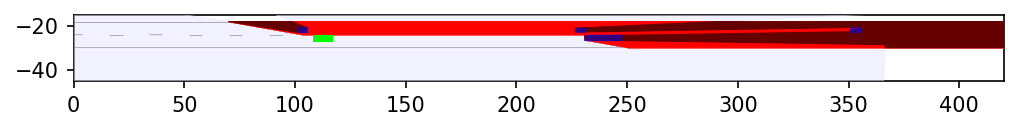

In [5]:
ego_vehicle = data["novel_method"]["ego_vehicle"]
scenarios = data["novel_method"]["scenarios"]
views = data["novel_method"]["views"]
simulation_length = data["simulation_length"]

fig = plt.figure(figsize=(12, 2), dpi=150)
anim = animation.FuncAnimation(fig,
                               plot_result_scenario, 
                               fargs=[ego_vehicle, scenarios, views], 
                               frames=simulation_length, 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())

#### Animation of baseline method

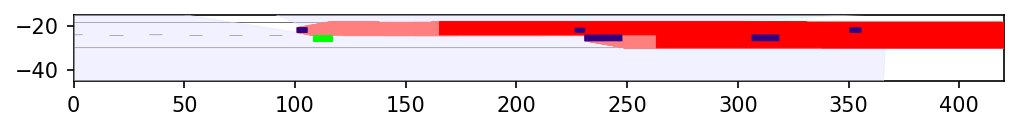

In [8]:
ego_vehicle = data["baseline_method"]["ego_vehicle"]
scenarios = data["baseline_method"]["scenarios"]
views = data["baseline_method"]["views"]
simulation_length = data["simulation_length"]

fig = plt.figure(figsize=(12, 2), dpi=150)
anim = animation.FuncAnimation(fig, 
                               plot_result_scenario, 
                               fargs=[ego_vehicle, scenarios, views], 
                               frames=simulation_length, 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())

#### Propagation of shadow volumes

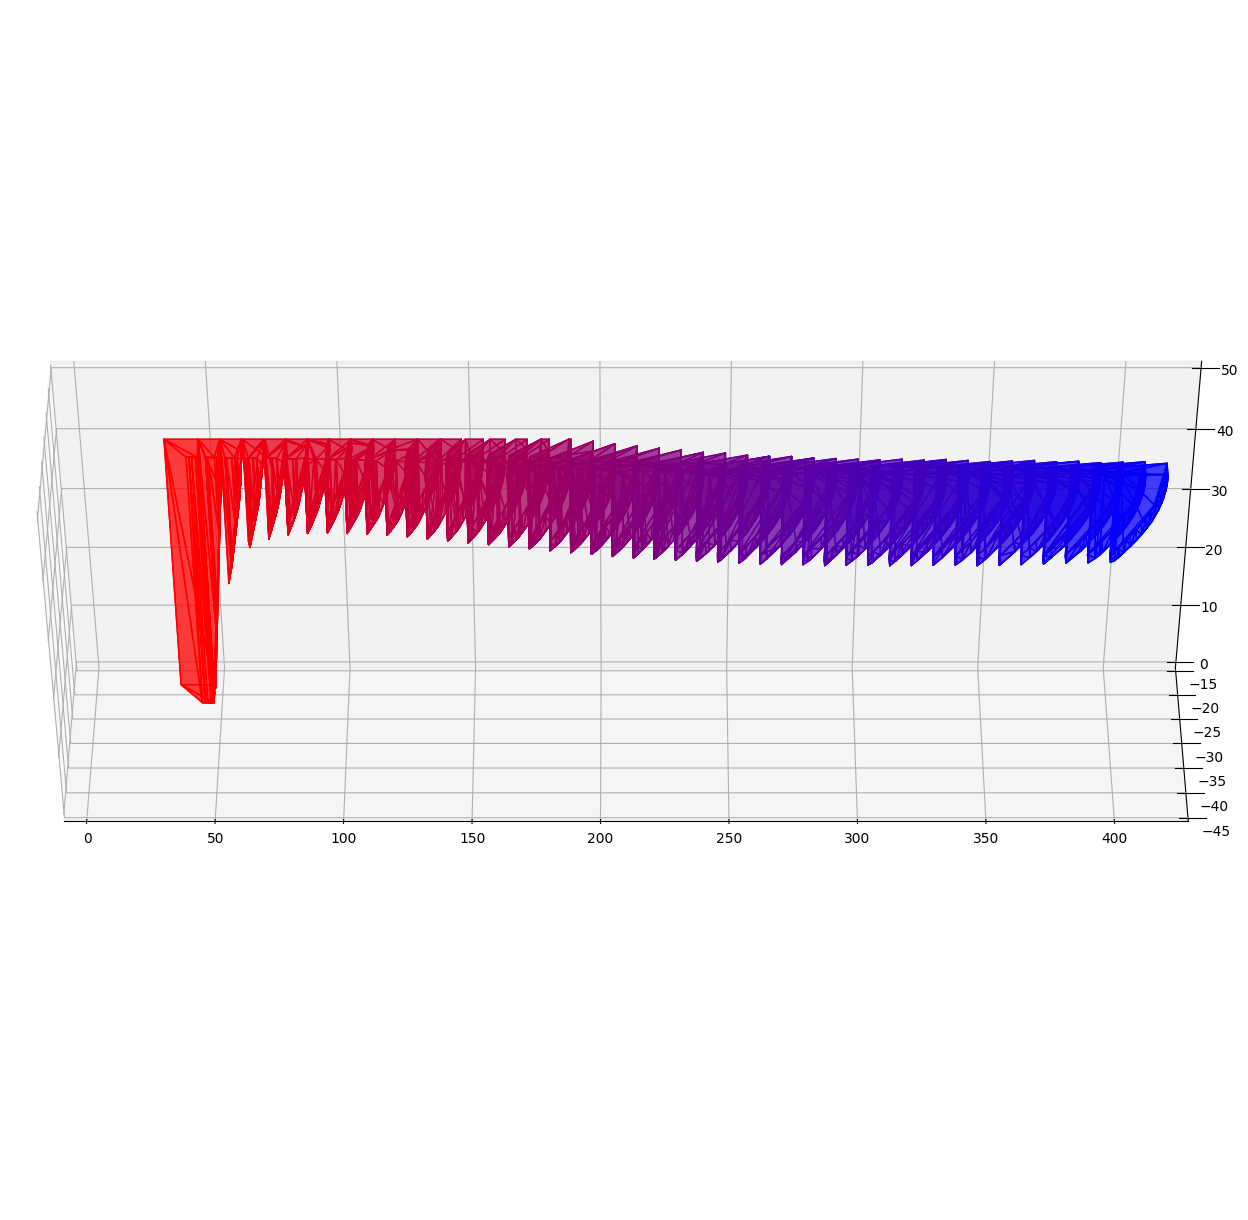

Update time novel method:  0.19916320645652172
Prediction time novel method:  0.6494476660434784
Update time baseline method:  0.07327589476086956
Prediction time baseline method:  1.0050035498478262


In [9]:
simulation_length = data["simulation_length"]
shadows_novel = data["novel_method"]["shadows"]
shadows_to_plot = [1]
if len(shadows_to_plot) == 0:
    shadows_to_plot = np.arange(len(shadows_novel))
for shadow in shadows_to_plot:
    Visualizer().plot_3D_shadows(shadows_novel[shadow],simulation_length,np.arange(0, simulation_length))

#### RSS distance comparisson

Text(0, 0.5, 'Distance Headway [m]')

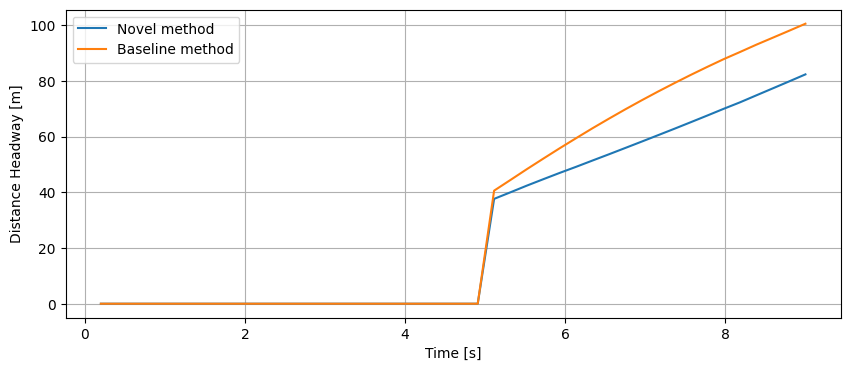

In [86]:
from python_scripts.utilities import find_RSS_distance

ego_novel = data["novel_method"]["ego_vehicle"]
ego_baseline = data["baseline_method"]["ego_vehicle"]
scenario = data["scenario"]
simulation_length = data["simulation_length"]

# Might need to rewrite RSS_distance function a bit
dists_novel = find_RSS_distance(ego_novel, scenario, config)
dists_baseline = find_RSS_distance(ego_baseline, scenario, config)
time = np.linspace(0.2, simulation_length/5, simulation_length-1) #assuming dt = 0.2

plt.figure(figsize=(10,4))
labels = ['Novel method','Baseline method']

plt.plot(time, dists_novel, label=labels[0])
plt.plot(time, dists_baseline, label=labels[1])
plt.legend()
plt.grid()

plt.xlabel('Time [s]')
plt.ylabel('Distance Headway [m]')

#### Velocity comparisson

(0.0, 9.0)

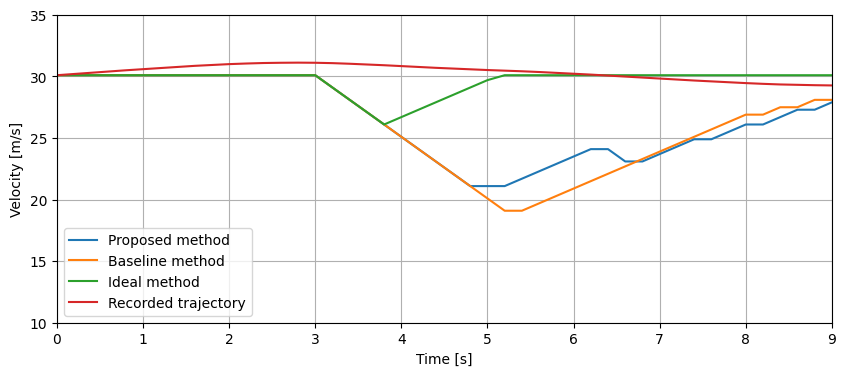

In [40]:
ego_novel = data["novel_method"]["ego_vehicle"]
ego_baseline = data["baseline_method"]["ego_vehicle"]
ego_ideal = data["ideal_method"]["ego_vehicle"]
ego_recorded = data["recorded_ego_speed"]

plt.figure(figsize=(10, 4))
labels = ['Proposed method','Baseline method', 'Ideal method', 'Recorded trajectory']
for idx, vehicle in enumerate([ego_novel, ego_baseline, ego_ideal]):
    velocities = [round(vehicle.initial_state.velocity, 2)]
    time = [round(vehicle.initial_state.time_step/10, 2)]
    for state in vehicle.prediction.trajectory.state_list:
        velocities.append(round(state.velocity, 2))
        time.append(round(state.time_step/5, 2))
    plt.plot(time, velocities, label=labels[idx])
plt.plot(time, ego_recorded[::5], label=labels[-1]) #forgot to downsample recorded vel
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid()
plt.ylim(10, 35)
plt.xlim(0,9)

#### Computational times

In [11]:
print("Update time novel method: ", data["novel_method"]["computational_time"]["update_step"])
print("Prediction time novel method: ", data["novel_method"]["computational_time"]["prediction_step"])
print("Update time baseline method: ", data["baseline_method"]["computational_time"]["update_step"])
print("Prediction time baseline method: ", data["baseline_method"]["computational_time"]["prediction_step"])

Update time novel method:  0.0750616485869565
Prediction time novel method:  2.0609161908913047
Update time baseline method:  []
Prediction time baseline method:  []


## Run all scenarios

In [7]:
skip_existing = True            # Skips any scenarios that already have existing results.
scenario_path = "scenarios/highd_scenarios"
results_path = "results/highd_simulations_pickle"

In [ ]:
path_xml = os.path.join(scenario_path, "*.xml")
path_yaml = os.path.join(scenario_path, "*.yaml")

xml_list = sorted(glob.glob(path_xml))
yaml_list = sorted(glob.glob(path_yaml))

with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)

for xml_file, yaml_file in tqdm.tqdm(zip(xml_list, yaml_list), total=len(xml_list), desc="Iterating over simulations"):
    scenario1, _ = CommonRoadFileReader(xml_file).open()
    scenario2, _ = CommonRoadFileReader(xml_file).open()
    with open(yaml_file) as file:
        scenario_config = yaml.load(file, Loader=yaml.FullLoader)
    config = merge_config(global_config, scenario_config)

    if skip_existing and os.path.isfile(os.path.join(results_path, str(scenario1.scenario_id))):
        continue

    try:
        config['occlusion_params']['velocity_tracking_enabled'] = True
        tracked_results = step_simulation(scenario1, config)

        config['occlusion_params']['velocity_tracking_enabled'] = False
        untracked_results = step_simulation(scenario2, config)

        save_path = os.path.join(results_path, str(scenario1.scenario_id))
        save_results(save_path, tracked_results, untracked_results, scenario1, scenario_config)
    
    except Exception as e:
        print("Simulation raised an error for scenario ", scenario1.scenario_id)

## Visualise all results

In [4]:
single_results_folder = "results/highd_simulations_pickle_new"
batch_results_path = "results/batch_results_new"

single_to_batch_results(single_results_folder, batch_results_path)

100%|██████████| 179/179 [02:07<00:00,  1.40it/s]


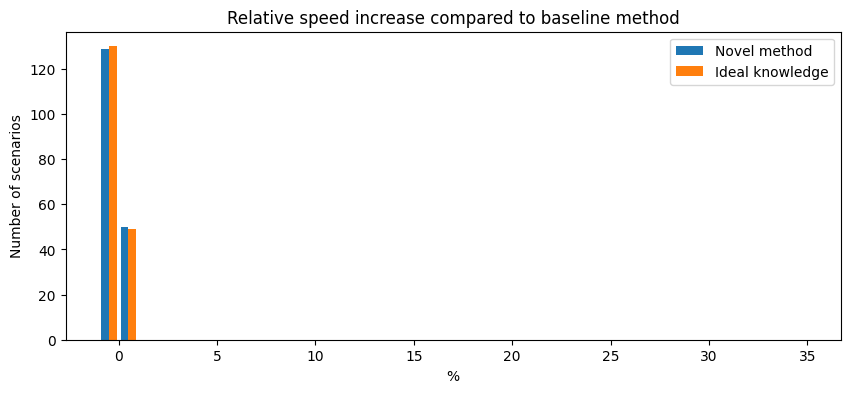

In [10]:
batch_results = pd.read_pickle(batch_results_path)

fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results["avg_vel_novel"]/batch_results["avg_vel_baseline"]-1)*100,
          (batch_results["avg_vel_ideal"]/batch_results["avg_vel_baseline"]-1)*100], 
          [-1, 0.0001, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
          label = ["novel method", "recorded_velocity"])
plt.title("Relative speed increase compared to baseline method")
plt.xlabel("%")
plt.ylabel("Number of scenarios")
plt.legend(["Novel method", "Ideal knowledge"])
plt.show()


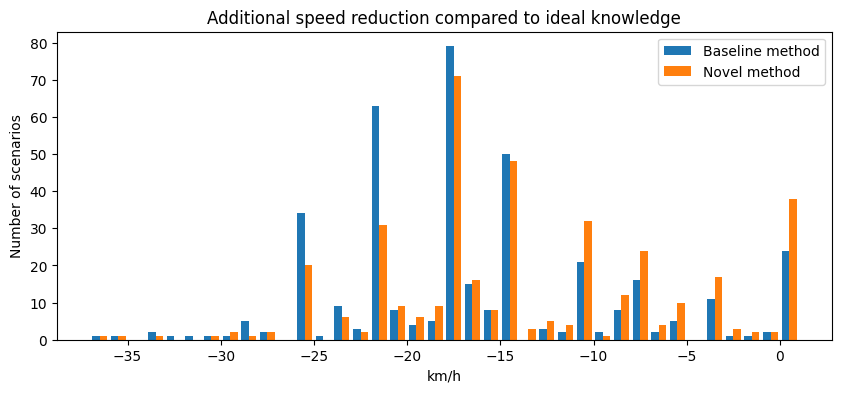

In [25]:
fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results["min_vel_baseline"] - batch_results["min_vel_ideal"])*3.6,
          (batch_results["min_vel_novel"] - batch_results["min_vel_ideal"])*3.6], 
         np.arange(-37.0001, 1.9999),
         label = ["novel method", "baseline method"])
plt.title("Additional speed reduction compared to ideal knowledge")
plt.xlabel("km/h")
plt.ylabel("Number of scenarios")
plt.legend(["Baseline method", "Novel method"])
plt.show()

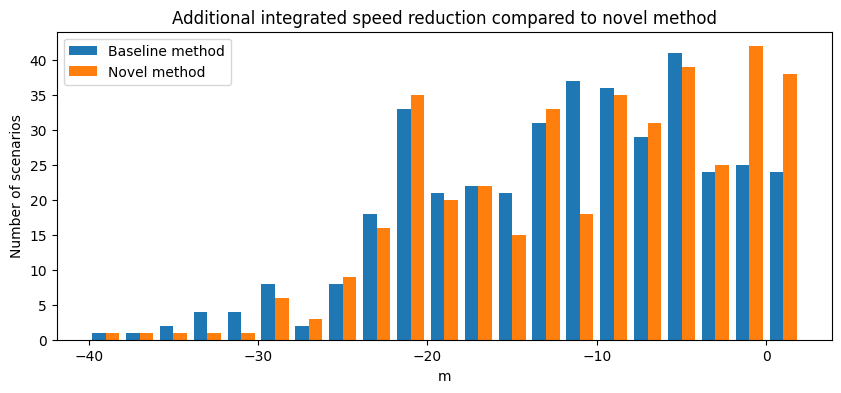

In [30]:
fig = plt.figure(figsize=(10,4))
plt.hist([batch_results["integrated_vel_reduction_baseline"] - batch_results["integrated_vel_reduction_ideal"],
          batch_results["integrated_vel_reduction_novel"] - batch_results["integrated_vel_reduction_ideal"]], 
         np.arange(-40.0001, 3.9999,2),
         label = ["novel method", "baseline method"])
plt.title("Additional integrated speed reduction compared to novel method")
plt.xlabel("m")
plt.ylabel("Number of scenarios")
plt.legend(["Baseline method", "Novel method"])
plt.show()

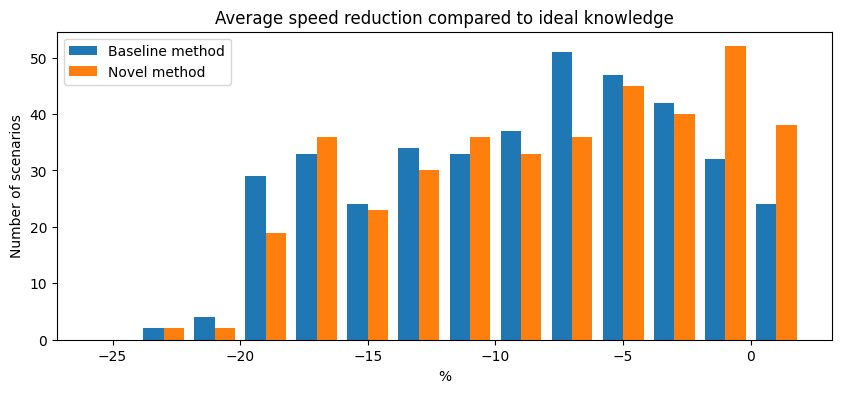

In [39]:
fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results["avg_vel_baseline"]/batch_results["avg_vel_ideal"]-1)*100,
          (batch_results["avg_vel_novel"]/batch_results["avg_vel_ideal"]-1)*100], 
          np.arange(-26.0001, 2.9999,2),
          label = ["Baseline method", "Novel method"])
plt.title("Average speed reduction compared to ideal knowledge")
plt.xlabel("%")
plt.ylabel("Number of scenarios")
plt.legend(["Baseline method", "Novel method"])
plt.show()

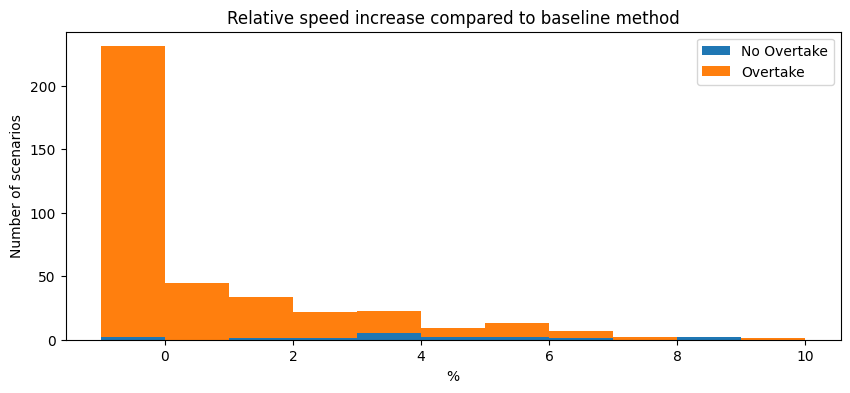

In [6]:
fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results[batch_results.is_overtake == True]["avg_vel_novel"]/batch_results[batch_results.is_overtake == True]["avg_vel_baseline"]-1)*100,
          (batch_results[batch_results.is_overtake == False]["avg_vel_novel"]/batch_results[batch_results.is_overtake == False]["avg_vel_baseline"]-1)*100], 
          [-1, 0.0001, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          stacked=True)
plt.title("Relative speed increase compared to baseline method")
plt.xlabel("%")
plt.ylabel("Number of scenarios")
plt.legend(["No Overtake", "Overtake"])
plt.show()

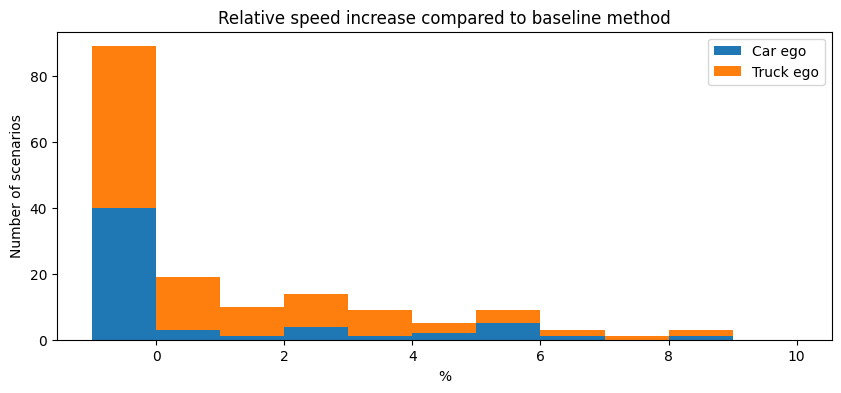

In [11]:
fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results[batch_results.vehicle_type == "Car"]["avg_vel_novel"]/batch_results[batch_results.vehicle_type == "Car"]["avg_vel_baseline"]-1)*100,
          (batch_results[batch_results.vehicle_type == "Truck"]["avg_vel_novel"]/batch_results[batch_results.vehicle_type == "Truck"]["avg_vel_baseline"]-1)*100], 
          [-1, 0.0001, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          stacked=True)
plt.title("Relative speed increase compared to baseline method")
plt.xlabel("%")
plt.ylabel("Number of scenarios")
plt.legend(["Car ego", "Truck ego"])
plt.show()

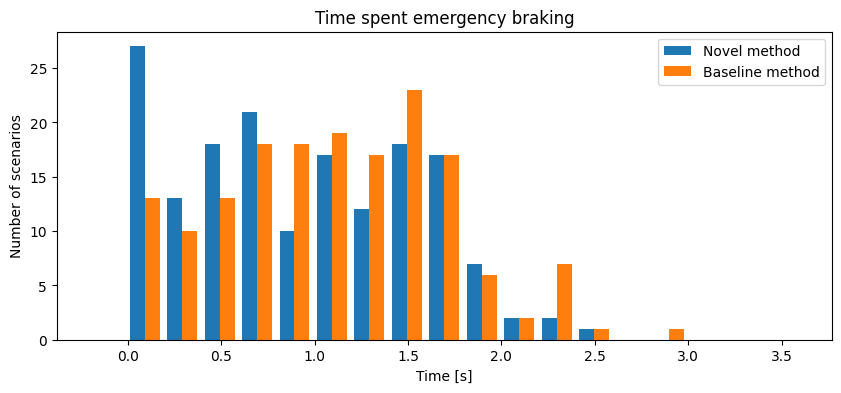

In [12]:
fig = plt.figure(figsize=(10,4))
plt.hist([batch_results["n_brakes_novel"]*0.2,
          batch_results["n_brakes_baseline"]*0.2], 
          np.linspace(-0.21, 3.6, 20))
plt.title("Time spent emergency braking")
plt.xlabel("Time [s]")
plt.ylabel("Number of scenarios")
plt.legend(["Novel method", "Baseline method"])
plt.show()

In [64]:
sorted_df = batch_results.sort_values("n_brakes_novel", ascending=False)

for i in range(10):
    print(sorted_df["scenario_id"].values[i])

ZAM_HighD-13_3_T-1
ZAM_HighD-48_11_T-1
ZAM_HighD-47_4_T-1
ZAM_HighD-37_5_T-1
ZAM_HighD-55_1_T-1
ZAM_HighD-48_4_T-1
ZAM_HighD-11_4_T-1
ZAM_HighD-31_9_T-1
ZAM_HighD-13_4_T-1
ZAM_HighD-39_4_T-1


In [116]:
batch_results["recorded_ratio"] = batch_results["avg_vel_recorded"]/batch_results["avg_vel_baseline"]
sorted_df = batch_results.sort_values("recorded_ratio", ascending=False)

for i in range(10):
    print(sorted_df["scenario_id"].values[i], sorted_df["recorded_ratio"].values[i]*100-100)
    print(sorted_df["avg_vel_recorded"].values[i], sorted_df["avg_vel_baseline"].values[i], sorted_df["ego_speed"].values[i])

ZAM_HighD-13_3_T-1 38.491037644486084
31.190000000000005 22.521312953164813 31.19
ZAM_HighD-48_11_T-1 35.68514217563239
30.88 22.758571428571432 30.88
ZAM_HighD-55_1_T-1 34.38577390673197
31.740000000000002 23.618571428571435 31.74
ZAM_HighD-35_2_T-1 32.84078601268757
24.53 18.46571428571429 24.53
ZAM_HighD-36_11_T-1 32.50863060989647
29.610000000000007 22.345714285714287 29.61
ZAM_HighD-6_12_T-1 31.751692977493263
22.985023923444974 17.445714285714292 23.01
ZAM_HighD-53_4_T-1 31.39213775178689
23.110000000000007 17.58857142857143 23.11
ZAM_HighD-6_7_T-1 30.843363093770023
30.46033492822967 23.280000000000005 30.48
ZAM_HighD-6_6_T-1 30.832666266426543
23.59473684210527 18.03428571428572 23.62
ZAM_HighD-18_1_T-1 30.40187088436204
30.269999999999992 23.21285714285715 30.27
